# Ranking of final results

The submitted results will be evaluated with the following equation:

𝑅 = 𝑚𝑒𝑎𝑛(0.2 ∗ 𝑇𝑅𝐸(𝑝) + 0.3 ∗ 𝐻𝐷(𝑝) + 0.5 ∗ 100 ∗ |𝑉𝑆(𝑝)|)

where
- TRE: Target registration error (can be calculated only for landmarks)
- HD: Hausdorff distance (sensible to outlayers)
- VS: Volume similarity. The volume similarity ranges from 0 to 1 but, in this case, it is between 0 and 0.05, so it is weighted by 100. This measure, due to the size of the lungs and the resolution of the CT is much less sensible to outliers and on average it outputs quite good results.
- p: index for each patient

The optimal result is R=0. We will use the same code given in the notebook to evaluate your
results.

In [12]:
import sys
sys.path.append('../SPIE2019_COURSE/')

In [13]:
import numpy as np
import os
import SimpleITK as sitk
import utilities 
import pandas as pd
from IPython.display import display, HTML 
from enum import Enum

Evaluation of subject 01:
R: 3.456523397402872

Evaluation of subject 02:
R: 5.528120362934699

Evaluation of subject 03:
R: 5.65950280531976

Evaluation of subject 04:
R: 4.90047161052913

Evaluation of subject 05:
R: 4.805991633549868

Evaluation of subject 06:
R: 3.754538945619561

Your final R-score is:

R: 4.684191459225982


,TRE,Hausdorff distance,Volume Similarity,R
01,1.364,10.466,-0.001,3.457
02,2.450,16.585,0.001,5.528
03,1.726,17.373,0.002,5.660
04,1.932,14.319,0.004,4.900
05,1.570,14.267,-0.004,4.806
06,1.320,11.590,-0.000,3.755


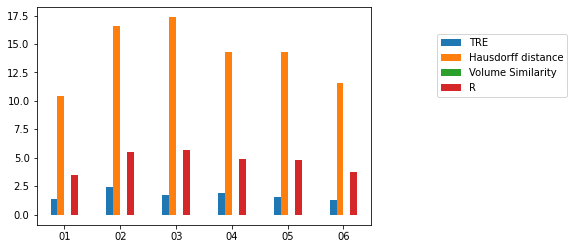

In [17]:
def mask_results(fixed_image_mask, moving_image_mask):    
    # Use enumerations to represent the various evaluation measures
    class OverlapMeasures(Enum):
        volume_similarity = range(1)

    class SurfaceDistanceMeasures(Enum):
        hausdorff_distance = range(1)
    
    # Often referred to as ground truth, but we prefer reference as the truth is never known.
    reference_segmentation = fixed_image_mask
    # Segmentations before and after registration
    segmentations = [moving_image_mask]

    # Empty numpy arrays to hold the results 
    overlap_results = np.zeros((len(segmentations),len(OverlapMeasures.__members__.items())))  
    surface_distance_results = np.zeros((len(segmentations),len(SurfaceDistanceMeasures.__members__.items())))  

    # Compute the evaluation criteria
    # Note that for the overlap measures filter, because we are dealing with a single label we 
    # use the combined, all labels, evaluation measures without passing a specific label to the methods.
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
    hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

    for i, seg in enumerate(segmentations):
        # Overlap measures
        overlap_measures_filter.Execute(reference_segmentation, seg)
        overlap_results[i,OverlapMeasures.volume_similarity.value] = overlap_measures_filter.GetVolumeSimilarity()
        # Hausdorff distance
        hausdorff_distance_filter.Execute(reference_segmentation, seg)
        surface_distance_results[i,SurfaceDistanceMeasures.hausdorff_distance.value] = hausdorff_distance_filter.GetHausdorffDistance()
    return overlap_results, surface_distance_results  

def ranking_measure(TRE, HD, VS):
    return 0.2*TRE + 0.3*HD + 0.5*(100*np.abs(VS))

def ranking(path2reference, path2registered):
    """
    path2reference: a folder containing two subfolders (masks and points). 
                    Masks contains 6 subfolders belonging to the subjects and on each subfolder, a mask in format 00.mhd.
                    The same applies for points, but the format now is given as 00.pts.txt
    path2registered: same as path2reference, but now the index should be 5 (i.e. 50.mhd and 50.pts.txt)
    """
    
    patients = 6 # Total number of patients to register
    timepoints = [0, 5] # Time points to register
    # Initialize ranking measures
    R = []
    for i in range(patients):
        # Subject number
        p = np.str('0{}'.format(i+1))
        print('Evaluation of subject {}:'.format(p))
        
        # Read reference input masks and landmarks
        mask_file_name = os.path.join(path2reference, 'masks', p, '{}0.mhd'.format(timepoints[0]))
        points_file_name = os.path.join(path2reference, 'landmarks', p, '{}0.pts.txt'.format(timepoints[-1]))
        fixed_image_mask = sitk.ReadImage(mask_file_name)
        fixed_image_mask = fixed_image_mask == 1
        fixed_points = utilities.read_POPI_points(points_file_name)

        # Read registered input masks and landmarks
        mask_file_name = os.path.join(path2registered, 'masks', p, '{}0.mhd'.format(timepoints[-1]))
        points_file_name = os.path.join(path2registered, 'landmarks', p, '{}0.pts.txt'.format(timepoints[0]))
        moving_image_mask = sitk.ReadImage(mask_file_name)
        moving_image_mask = moving_image_mask == 1
        moving_points = utilities.read_POPI_points(points_file_name)
        
        # Evaluate the registration
        volume_similarity, hausdorff_distance = mask_results(fixed_image_mask, moving_image_mask)
        TRE = utilities.target_registration_errors(sitk.Transform(), fixed_points, moving_points)
        R_subject = ranking_measure(np.mean(TRE), np.mean(hausdorff_distance),np.mean(volume_similarity))   
        print('R: {}\n'.format(R_subject))    
        R.append([np.mean(TRE), np.mean(hausdorff_distance), np.mean(volume_similarity), R_subject])
    
    # Results matrix will be stored into a pandas data frame 
    registration_results = pd.DataFrame(data = R, index=[np.str('0{}'.format(i+1)) for i in range((patients))], 
                                  columns=['TRE', 'Hausdorff distance', 'Volume Similarity', 'R'])
    print('Your final R-score is:\n')
    print('R: {}'.format(np.mean(registration_results['R'])))
    
    
    # Display the data as HTML tables and graphs
    display(HTML(registration_results.to_html(float_format=lambda x: '%.3f' % x)))
    registration_results.plot(kind='bar', rot=1).legend(bbox_to_anchor=(1.6,0.9))
    
    return registration_results


# Set the path to the masks
path2reference = "./data"
path2registered = "./final_results"

R = ranking(path2reference, path2registered)
